In [1]:
import numpy as np

In [16]:


#standard '802.11a'                 
#frame_aggregation
N1 = np.arange(5.,55.,5)
                           
#L_data = np.arange(3., 8., 1.)          
L_data = np.arange(100, 1500, 100)

Max_frames = 64.
Max_length = 64e3         
Max_time = 5458.


W = 15.
m = 6.


In [17]:
L_data

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400])

In [39]:
N_DBPS = [26., 78]
DIFS = 34.       
SIFS = 16.

In [40]:
sigma = 9.                          
delta = 1. 
T_sym = 4.

In [41]:
L_header = 36.
L_ACK = 14.
L_delimiter = 4.
L_blockACK = 32.

In [42]:
S = np.zeros([len(N_DBPS), len(N1), len(L_data)])

In [43]:
import math

In [44]:
for i in range(0, len(N1)):
    if (N1[i] == 1):
        p = 0.
        tau = 2./(W + 1)
    else:
        inc = 0.000001
        error_MAX = 0.000005
        p = 0.
        tau1 = 0.
        tau2 = tau1 + 2.*error_MAX

        while (math.fabs(tau1 - tau2) > error_MAX):
            p = p + inc
            tau1 = 2.*(1.-2.*p)/((1.-2.*p)*(W + 1.) + p*W*(1.-(2.*p)**m))
            tau2 = 1. - (1.-p)**(1./(N1[i]-1))
        tau = (tau1 + tau2)/2. 

    P_tr = 1. - (1. - tau)**(N1[i])
    
    P_s = N1[i]*tau*(1.- tau)**(N1[i]-1)
            
    P_c = P_tr - P_s
    
    P_e = 1. - P_tr
    
    for j in range(0, len(N_DBPS)):
        for k in range(0, len(L_data)):
            K = Max_frames
            valid_K = False
            
            while(K > 0 and valid_K == False):
                agg_frame = (L_header + L_data[k])*8.*K + (K - 1.)*L_delimiter*8.
                if(agg_frame <= Max_length*8.):
                    N_sym_data = (22. + agg_frame)/N_DBPS[j]
                    N_ACK = (22. + (L_ACK*8.))/N_DBPS[j]
                    T_data = 40. + 4.*math.ceil(T_sym*N_sym_data/4.) 
                    T_ACK = 40. + 4.*math.ceil(T_sym*N_ACK/4.)
                        
                    if (T_data <= Max_time):
                        valid_K = True
                K = K - 1.
            K = K + 1.
             
            
            T_s = DIFS + T_data + 2.*delta + SIFS + T_ACK

            T_c = DIFS + T_data + delta

            E_s = P_e*sigma + P_s*T_s + P_c*T_c

            S[j][i][k] = P_s*L_data[k]*K*8./E_s


In [45]:
import matplotlib.pyplot as plt

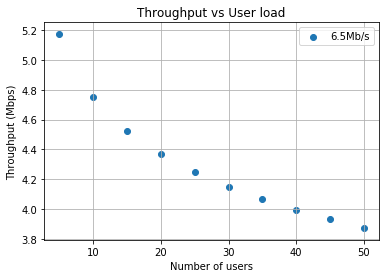

In [47]:
plt.scatter(N1, S[0,:,-1], label = '6.5Mb/s')
plt.xlabel('Number of users')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs User load')
plt.grid()

In [26]:
from scipy.optimize import root
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
def durations(sigma, SIFS, DIFS, data, ack):
    T_id = sigma
    T_c = data + DIFS + sigma
    T_s = data + SIFS + sigma + ack + DIFS + sigma
    return T_id, T_c, T_s

In [28]:
def eq(CW_min, T_id, T_c, T_s, m, N, pi, p):
    eq7 = pi - 2 / (1 + CW_min + p*CW_min * sum(map(lambda k: (2*p)**k, range(0, m))))
    eq1 = p - 1 + (1-pi)**(N-1)
    return eq7, eq1

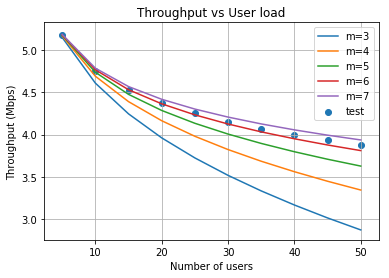

In [51]:
DIFS=34; SIFS=16; slot=9
data=1430; ack=60; l=1200 #* 10**6
CW_min=15
T_id, T_c, T_s = durations(slot, SIFS, DIFS, data, ack)
for m in range(3, 8):
    N = range(5, 55, 5)
    throughput = []
    for n in N:
        pi, p = root(lambda z: eq(CW_min, T_id, T_c, T_s, m, n, pi=z[0], p=z[1]), [0.9, 0.1]).x
        p_tr = 1 - (1-pi)**n
        p_s = n * pi * (1-pi)**(n-1) / (1 - (1-pi)**n)
        throughput.append(p_s * p_tr * l / (
        p_s * p_tr * T_s + p_tr*(1 - p_s )*T_c + (1 - p_tr )*T_id) * 8) #because we want bps)
    plt.plot(N, throughput, label="m={}".format(m))
plt.scatter(N1, S[0,:,-1], label = 'test')
plt.xlabel('Number of users')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.title('Throughput vs User load')
plt.grid()
plt.show()